In [1]:
import pandas as pd
from ugvc.reports.report_utils import ShortReportUtils, parse_config
from ugvc.reports.report_data_loader import ReportDataLoader
from IPython.display import display, Markdown

pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)

In [10]:
run_id = "NA"
pipeline_version = "NA"
h5_concordance_file = "NA"
verbosity = 1
reference_version = "hg38"
truth_sample_name = "NA"
h5outfile = "var_report.h5"    
model_name_with_gt = None
model_name_without_gt = None
model_pkl_with_gt = None
model_pkl_without_gt = None
model_name = None

In [21]:
parameters = {
    'h5_concordance_file': h5_concordance_file,
    'run_id': run_id,
    'pipeline_version': str(pipeline_version),
    'verbosity': str(verbosity),
    'reference_version': reference_version,
    'truth_sample_name': truth_sample_name,
    'h5outfile': h5outfile,
    'model_name_with_gt': model_name_with_gt,
    'model_name_without_gt': model_name_without_gt,
    'model_pkl_with_gt': model_pkl_with_gt,
    'model_pkl_without_gt': model_pkl_without_gt,
    'model_name': model_name
}

parameters = {name: parameters[name] for name in parameters if parameters[name] is not None}
param_names = list(parameters)

report_utils = ShortReportUtils(verbosity, h5outfile)

if verbosity > 1:
    display(Markdown(f"# Variant Calling report v{pipeline_version} (INTERNAL usage)"))
else:
    display(Markdown(f"# Variant Calling report v{pipeline_version}"))

# Variant Calling report vNA

## 1. Input Parameters

In [12]:
# load data
data_loader = ReportDataLoader(concordance_file=parameters['h5_concordance_file'],
                               reference_version=reference_version)
data = data_loader.load_concordance_df()

In [22]:
if 'well_mapped_coverage' in data.columns:
    parameters['mean_var_depth'] = '{:.2f}'.format(data['well_mapped_coverage'].mean())
    param_names.append('mean_var_depth')

parameters_df = pd.DataFrame.from_dict(parameters, orient='index', columns=['value']).reindex(param_names)
parameters_df.to_hdf(h5outfile, key="parameters")
display(parameters_df)

,value
h5_concordance_file,output_vcf_eval_outputs.comp.h5
run_id,NA
pipeline_version,NA
verbosity,1
reference_version,hg38
truth_sample_name,NA
h5outfile,var_report.h5


## 2. Performance over all Data
The concordance between the variant calling results and the ground truth sample is presented below.
* Red line - precision and recall over different tree-scores.
* Red dot - precision and recall values for the chosen threshold.
* Black dot -precision and recall after filtering systematic errors (SEC)

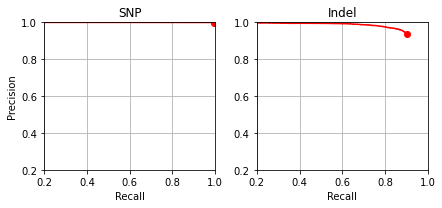

,true vars,fn,fp,fp(filter),precision,F1
SNP,69175,460,81,81,99.88%,99.61%
Indel,9986,986,600,600,93.75%,91.90%


""


In [23]:
pd.options.display.float_format = '{:,.2%}'.format
if verbosity > 1:
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
              'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8',
              'hmer Indel >8,<=10', 'hmer Indel >10,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
else:
    categories = ['SNP', 'Indel']

report_utils.basic_analysis(data, categories, 'all_data', 'sec_data')

In [ ]:
if verbosity > 1:
    display(Markdown(f"## 2.1 Stratified by base"))
    display(Markdown(f"#### (A,T)"))
    categories = ['SNP', 'Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10',
                  'hmer Indel >10,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
    at_df = report_utils.base_stratification_analysis(data, categories, ('A', 'T'))

In [ ]:
if verbosity > 1:
    display(Markdown(f"#### (G,C)"))
    categories = ['SNP', 'Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10']
    gc_df = report_utils.base_stratification_analysis(data, categories,('G', 'C'))   

In [ ]:
if verbosity > 1:
    display(Markdown(f"### 2.2 Homozygous genotyping accuracy"))
    display(Markdown(f"The precision and recall of called homozygous variants (where the variant was not classified as False Negative)"))
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 
                  'hmer Indel >8,<=10', 'hmer Indel >10,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
    df = report_utils.homozygous_genotyping_analysis(data, categories, "wg_homozygous")

## 3. Performance over UG high confidence regions

Variant calling peformance exclusing genomic areas where UG performance is poor, i.e:
- Homopolymers - runs of length 11 bp and above, padded with four bases around the genomic coordinates,
- AT-rich regions - bases where the GC content of the surrounding 40 bases is lower than 5%,
- Tandem repeats,
- Low mapping quality - regions that are covered by at least 20 reads, but less than 10% of these reads are aligned with mapping quality > 20,
- High coverage variability - regions with coverage that is highly variable between samples (std/mean > 0.5)

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format
ug_hcr_data = data.query("ug_hcr==True").copy()

if verbosity > 1:
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
              'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8', 'hmer Indel >8,<=10']
else:
    categories = ['SNP', 'Indel']
    
report_utils.basic_analysis(ug_hcr_data, categories, 'ug_hcr', 'ug_hcr_sec_data')

In [ ]:
if verbosity > 1:
    display(Markdown(f"### 3.1 Homozygous genotyping accuracy"))
    display(Markdown(f"The precision and recall of called homozygous variants (where the variant was not classified as False Negative)"))
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10']
    df = report_utils.homozygous_genotyping_analysis(ug_hcr_data, categories, "ug_hcr_homozygous")

In [ ]:
d = data
if 'well_mapped_coverage' in d.columns and verbosity > 1:
    display(Markdown(f"## 4. Performance over regions with coverage>=20 and excluding areas with mappability"))    
    good_cov_data = d[(d['well_mapped_coverage'] >= 20) & (d['mappability.0'])].copy()
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
                  'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8', 'hmer Indel >8,<=10']
    df = report_utils.basic_analysis(good_cov_data, categories, 'good_cvg_data')
    
    display(Markdown(f"### 4.1 Homozygous genotyping accuracy"))
    display(Markdown(f"The precision and recall of called homozygous variants (where the variant was not classfied as False Negative)"))
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8']
    report_utils.homozygous_genotyping_analysis(good_cov_data, categories, "good_cvg_data_homozygous")